In [1]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import random
import gym
from math import sqrt
from scipy.stats import t
from statistics import mean
from tqdm import tqdm
from abc import ABC, abstractmethod
import seaborn as sns
import pickle
#from google.colab import drive

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.express as px

from abc import ABC, abstractmethod
from tqdm.notebook import tqdm

from utils.agent_creator import AgentCreator
from utility_functions import ProspectUtilityFunction
from environments.multi_armed_bandit import MultiArmedBanditEnvironment
from rewards import MultinomialReward
from agents import EpsilonGreedyAgent, SocialAgent
from results import ActionsResult
from visualizers.probability_of_choosing_best_action import ProbabilityOfChoosingBestActionVisualizer

In [2]:
#from google.colab import drive
# drive.mount('/content/drive')

# Implementations

## Rewards

In [3]:
class MultinomialReward():
    def __init__(self, rewards, probs):
        """
        rewards: a list of rewards are given by an specific arm
        probs: a list of probabilities correspondant to each reward in rewards list
        """
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)        

    def get_reward(self, t):
        return random.choices(self.rewards, weights = self.probs, k = 1)[0]

    def exp_u(self, agent):
        u = [agent.utility_function(r) for r in self.rewards]
        exp_u = np.array(self.probs) @ np.array(u)  
        return exp_u

In [4]:
class DeteriministicReward():
    def __init__(self, reward):
        """
        rewards: a list of rewards are given by a specific arm
        """
        self.reward = reward
        self.mean = reward
        
    def get_reward(self, t):
        return self.reward
    
    def exp_u(self, agent):
        u = agent.utility_function(self.mean) 
        exp_u = u
        return exp_u

In [5]:
class GaussianReward():
    def __init__(self, mean, std):
        """
        mean: a float shows the mean of gaussian distribution related to reward are given by a specific arm 
        std: a float shows the standard deviation of gaussian distribution related to reward are given by a specific arm
        """
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return np.random.normal(loc=self.mean, scale=self.std)
    
    def exp_u(self, agent, n_samples = 1000):
        utility_distribution = [agent.utility_function(np.random.normal(loc=self.mean, scale=self.std)) for i in range(n_samples)]
        return mean(utility_distribution)

In [6]:
class Students_t_distReward():
    def __init__(self,dof, mean, std):
        """
        dof: an integer shows degree of freedom for t-distribution
        mean: a float shows the mean of gaussian distribution related to reward are given by a specific arm 
        std: a float shows the standard deviation of gaussian distribution related to reward are given by a specific arm
        """
        self.dof = dof
        self.mean = mean
        self.std = std

    def get_reward(self, t):
        return t.rvs(df = self.dof, loc=self.mean, scale=self.std)

In [7]:
class MultinomialReward_NonStationary():
    def __init__(self, rewards, probs, switch_t):
        """
        rewards: a list of rewards are given by an specific arm
        probs: a list of probabilities correspondant to each reward in rewards list
        switch_t: an integer determine the swtich time
        """
        self.rewards = rewards
        self.probs = probs
        self.mean = np.array(probs) @ np.array(rewards)  
        self.switch_t = switch_t

    def get_reward(self, t):
        if t < self.switch_t:
            return random.choices(self.rewards, weights = self.probs, k = 1)[0]
        
        else:
            return random.choices(self.rewards[::-1], weights = self.probs, k = 1)[0]
    
    def exp_u(self, agent):
        u = [agent.utility_function(r) for r in self.rewards]
        exp_u = np.array(self.probs) @ np.array(u)  
        return exp_u

## N-Armed Bandit Environments

In [8]:
class MutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id = None, container=None):
        """
        rewards: a list of reward object, length = number of arms
        episode_max_length: maximum length of each episode 
        id: id of environment
        container: 
        """
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.state = None
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action

    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [9]:
class SocialMutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id = None, container = None):
        """
        rewards: a list of reward object, length = number of arms
        episode_max_length: maximum length of each episode 
        id: id of environment
        container: 
        """
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(len(rewards))
        
        if container != None:
            container.register_environment(self)

        self.id = id
        self.arms_rewards = rewards
        self.agents_last_choice = {}
        self.episode_max_length = episode_max_length
        # self.optimal_action = np.argmax(R_mean)

        self.state = {
            'length': 0,
            'last_action': None
        }
    
    def add_agent(self, agent_id):
        self.agents_last_choice[agent_id] = -1 
     
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])
    
    def update_selected(self, actions, agents_id):
        if len(actions) != len(agents_id):
            raise("WTF?")
        for i in range(len(actions)):
            self.agents_last_choice[agents_id[i]] = actions[i]
        
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}
    
    def n_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self):
        return {} 

    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe()
        info = self.get_info()
        self.next_state(action)
        done = self.terminated()
        # self.update_selected(action, agent_id) #agent_id == -1 ==> do nothing
        return observation, reward, done, info
    
    def config(self):
        self.agents_last_choice = []
    
    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None
        for key in list( self.agents_last_choice.keys()):
            self.agents_last_choice[key] = -1
    
    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

## Agents 

In [10]:
class AgentBase:
    def __init__(self, lr, environment = None, alpha = 1,beta = 1,gamma = 1,
                 lr_decay = 1):
        """
        environment: the env object that agent interact with it
        id: an int, the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        self.environment = environment
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.lr = lr
        self.lr_decay = lr_decay

    def set_environment(self, env):
        self.environment = env

    def set_id(self, id):
        self.id = id 

    @abstractmethod
    def take_action(self) -> (object, float, bool, object):
        # in this method, you MUST call the `step` method of 
        # the environment and observe the results and return them like:
        # return observation, reward, done, info
        pass
    
    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 

### Learner Agents

In [11]:
class EpsilonGreedyAgent(AgentBase): 
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1, lr = None,
                 lr_decay = 1, epsilon = 0.1, epsilon_decay = 1,  optimistic = False):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        epsilon = a float number, determine degree of exploration
        epsilon_decay = a float number, determine degree of decaying epsilon
        optimistic = a bool, determine using optimistic initialization
        """
        #Add Temperature
        super(EpsilonGreedyAgent, self).__init__(lr, environment, alpha, beta, gamma,  lr_decay)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            
            self.Q = np.zeros((self.n_actions))     #action value fuction
            # self.Q = np.random.normal(size=(self.n_actions,1))
            self.N = np.zeros((self.n_actions))     #number of doing an action 

    def get_number_actions(self):
        return self.N
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()

        self.Q = np.zeros((self.n_actions))     #action value fuction
        # self.Q = np.random.normal(size=(self.n_actions,1))
        self.N = np.zeros((self.n_actions))     #number of doing an action 

    def update(self, action, utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

    def select_action(self):
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
            # max_indices = np.argwhere(self.Q == np.amax(self.Q)).flatten()
            # action = int(np.random.choice(max_indices))
            # action = np.argmax(self.Q)
        return action

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action,u)
        
        return r, action , u

    def get_Q(self):
        return self.Q

In [12]:
class UCBAgent(AgentBase):
    def __init__(self, c, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = None, lr_decay = 1,):
        """
        c: a float, determine the degree of exploration 
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(UCBAgent, self).__init__( lr, environment, alpha, beta, gamma, lr_decay)
        self.c = c
        self.trial = 0                                          #number of total trials 

        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.Q = np.zeros((self.n_actions))                 #action value function(expected reward) for each arm
            self.N = np.zeros((self.n_actions))                 #number of doing each arm
            self.UCB = np.zeros((self.n_actions))      #Upper confidence bound for each arm
            
    def select_action(self): 
        # An action not chosen so far is the maximizer by default
        zero_idx = np.where(self.N == 0)[0]
        if len(zero_idx) > 0:
            return zero_idx[0]       
            
        self.UCB = self.Q + np.sqrt(self.c * np.log(self.trial+1)/(self.N))
        action = np.random.choice(np.flatnonzero(self.UCB == self.UCB.max()))
        return action 

    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()
        self.Q = np.zeros((self.n_actions))                 #action value function(expected reward) for each arm
        self.N = np.zeros((self.n_actions))                 #number of doing each arm
        self.UCB = np.zeros((self.n_actions))      #Upper confidence bound for each arm

    def update(self, action, u):        
        # update action values
        self.trial += 1
        self.N[action] = self.N[action] + 1
        if self.lr is not None:
            self.Q[action] += self.lr*(u-self.Q[action])
            self.lr = self.lr * self.lr_decay
        else:
            self.Q[action] += (u-self.Q[action]) / self.N[action]

        
    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Environment is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        return r, action, u

In [13]:
class GradientBanditAgent(AgentBase): 
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1, optimistic = False, Baseline_lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        optimistic = a bool, determine using optimistic initialization
        baseline_lr: a float number, determine the rate of updating the baseline
        """
        super(GradientBanditAgent, self).__init__(lr, environment, alpha, beta, gamma, lr_decay)

        self.R_lr = Baseline_lr
        self.avg_rew = 0   
        self.N = 0      
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.H = np.zeros((self.n_actions))
            self.P = (1/self.n_actions)*np.ones((self.n_actions))
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()
        self.H = np.zeros((self.n_actions))
        self.P = (1/self.n_actions)*np.ones((self.n_actions))       

    def update(self, action, utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.R_lr is not None:
            self.avg_rew += (utility - self.avg_rew) * self.R_lr
        else:
            self.avg_rew += (utility - self.avg_rew)/self.N

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.avg_rew)*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.avg_rew)*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        action = int(np.random.choice(list(range(self.n_actions)), size=1,p=self.P))       
        return action 

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u


In [14]:
class ActorCriticAgent(AgentBase): 
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1, optimistic = False):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        optimistic = a bool, determine using optimistic initialization
        """
        super(ActorCriticAgent, self).__init__(lr, environment, alpha, beta, gamma, lr_decay)
        self.N = 0      
        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.Q = np.zeros((self.n_actions))     #action value fuction
            self.H = np.zeros((self.n_actions))
            self.P = (1/self.n_actions)*np.ones((self.n_actions))
    
    def set_environment(self, env):
        self.environment = env
        self.n_actions = self.environment.n_actions()
        self.Q = np.zeros((self.n_actions))     #action value fuction
        self.H = np.zeros((self.n_actions))
        self.P = (1/self.n_actions)*np.ones((self.n_actions))        

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.Q[i])*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.Q[i])*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def select_action(self):
        action = int(np.random.choice(list(range(self.n_actions)), size=1,p=self.P))  
        return action

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("environment is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u

In [15]:
class ThompsonSamplingAgent(AgentBase):
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = 0.1, lr_decay = 1):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(ThompsonSamplingAgent, self).__init__(lr, environment, alpha, beta, gamma, lr_decay)
        
        if self.environment is not None:
            self.n_actions = self.environment.n_actions()
            self.stds = list(1000000000 * np.ones((self.n_actions,1)))  #stds of estimated gaussian distributions
            self.means = list( np.zeros((self.n_actions,1)))            #means of estimated gaussian distributions

    def set_environment(self, env):
        self.environment = env 
        self.n_actions = self.environment.n_actions()
        self.stds = list(1000000000 * np.ones((self.n_actions,1)))  #stds of estimated gaussian distributions
        self.means = list( np.zeros((self.n_actions,1)))            #means of estimated gaussian distributions

    def get_samples(self,means,stds):
        samples = [np.random.normal(means[i],stds[i]) for i in range(len(means))]
        return samples

    def update(self, action, reward):
        new_std = sqrt( 1 / ((1/self.stds[action]**2) + 1) )
        new_mean = (reward + (self.means[action] / self.stds[action] ** 2)) / ((1/self.stds[action]**2) + 1) 
        self.means[action] = new_mean
        self.stds[action] = new_std
        return 

    def select_action(self):
        samples = self.get_samples(self.means,self.stds)
        action = np.argmax(samples)
        return action 

    def take_action(self):# -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined",)
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        #print(obs, r, d, i)
        #self.environment.render()
        return r,action, u

### Coded Agents:

In [16]:
class AlwaysBestAgent(AgentBase):
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1, lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysBestAgent, self).__init__(lr, environment, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        # self.regret = []
    
    def set_environment(self, env):
        self.environment = env 
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max())) 
           
    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        obs, r, d, i = self.environment.step(self.bestaction, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].mean
        #self.regret.append(self.r)
        return r, self.bestaction, self.utility_function(r)

In [17]:
class PercentBestAgent(AgentBase):
    def __init__(self, p, environment = None, alpha = 1, beta = 1, gamma = 1, 
                 increase = 0, limit = 1, zero_at = False, lr = None):
        """
        p: a float number between 0 and 1, determine the proportion of selecting the optimal arm
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        increase: a float number between 0 and 1, determine the amount of selecting the optimal arm
        limit: a float number between 0 and 1, determine the upper bound of selecting the optimal arm
        zero_at: a bool, determine that we revert the selecting probability to zero after reaching to one 
        """
        super(PercentBestAgent, self).__init__(lr, environment, alpha, beta, gamma)
        self.p = p
        self.increase = increase
        self.zero_at = zero_at
        self.limit = limit
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
            self.n_actions = self.environment.n_actions()
            # self.regret = []
    
    def set_environment(self, env):
        self.environment = env
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.bestaction = np.random.choice(np.flatnonzero(self.EU == self.EU.max()))
        self.n_actions = self.environment.n_actions() 

    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        
        if np.random.rand() < self.p:
            action = self.bestaction
        else:
            action = np.random.choice(self.n_actions)
        
        obs, r, d, i = self.environment.step(action, self.id)

        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)

        self.p = self.p + self.increase
        if self.p > self.limit:
            self.p = self.limit
            self.increase = 0
            
        if self.zero_at:
            if self.p > 1:
                self.p = 0
                self.increase = 0
        return r, action, self.utility_function(r)
        

In [18]:
class SecondBestAgent(AgentBase):
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1, lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(SecondBestAgent, self).__init__(lr, environment, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            SecondEU = np.array([x for x in self.EU if x < max(self.EU)])
            self.secondbestaction = np.random.choice(np.flatnonzero(self.EU == SecondEU.max()))
            # self.regret = []

    def take_action(self):
        obs, r, d, i = self.environment.step(self.secondbestaction, self.id)
        return r, self.secondbestaction, self.utility_function(r)
    

In [19]:
class AlwaysWorstAgent(AgentBase):
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1, lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysWorstAgent, self).__init__(lr, environment, alpha, beta, gamma)
        if self.environment is not None:
            self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
            self.worstaction = np.random.choice(np.flatnonzero(self.EU == self.EU.min()))
        # self.regret = []

    def set_environment(self, env):
        self.environment = env    
        self.EU = np.array([self.utility_function(r.mean) for r in self.environment.arms_rewards])
        self.worstaction = np.random.choice(np.flatnonzero(self.EU == self.EU.min()))
            
    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")
        obs, r, d, i = self.environment.step(self.worstaction, self.id)
        return r, self.worstaction, self.utility_function(r)
    

In [20]:
class AlwaysRandomAgent(AgentBase):
    def __init__(self, environment = None, alpha = 1, beta = 1, gamma = 1, lr = None):
        """
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        """
        super(AlwaysRandomAgent, self).__init__(lr, environment, alpha, beta, gamma)
        if self.environment is not None:
            self.n_actions = self.environment.n_actions()
            # self.regret = []

    def set_environment(self, env):
        self.environment = env 
        self.n_actions = self.environment.n_actions()

    def take_action(self):
        if self.environment is None:
            raise("environment is not defined")        
        action = np.random.choice(self.n_actions)
        obs, r, d, i = self.environment.step(action, self.id)
        return r, action, self.utility_function(r)

Agent id -1 is equivalant to None

## Social Learning

In [21]:
class LastActionSocialStrategy():
    def __init__(self):
        """
        In this social strategy the learner copies the last action of the 
        selected agent in the society.
        """
        self.n = 1
        
    def set_environment(self, env):
        self.env = env
        self.agents_id = list(env.agents_last_choice.keys())
    
    def select_action(self, social_information, agent_id):
        # Choose the last action of agent from environment lookup table or your short-term memory  
        return self.env.agents_last_choice[agent_id]

In [22]:
class MostFrequentSocialStrategy():
    def __init__(self):
        """
        In this social strategy the learner copies the most frequent action of 
        the selected agent in the society.
        """
        self.n = 1
    
    def set_environment(self, env):
        self.env = env
        self.agents_id = list(env.agents_last_choice.keys())
    
    def select_action(self, social_information, agent_id):
        # Choose the most frequent action of agent from your long-term memory      
        return np.argmax(social_information[agent_id,:])

In [23]:
class PreferenceBasedSocialAgent(AgentBase):

    def __init__(self, ilm, lr = 0.1, env = None, alpha = 1,beta = 1,gamma = 1,):
        """
        # TODO: Comment update other agents in same list(line 51)
        # TODO: Change name of preference history to selecting policy history
        ilm: an individual learner object
        lr: an integer which set the learning rate
        env: an environment object
        """
        super(PreferenceBasedSocialAgent, self).__init__(lr, env, alpha = alpha, beta = beta, gamma = gamma)
        self.ilm = ilm 
        self.t = 0 #trial
        self.total_mean_reward = 0 
        self.selecting_history = []
        self.actions = []

        if self.environment is not None:
            self.n = len(self.environment.agents_last_choice) # number of agents
            self.k = self.environment.n_actions() # number of actions
            self.preferences = np.zeros(self.n)+0.0001
            self.lrs = np.ones(self.n)*lr
            self.social_information = np.zeros((self.n,self.k))
            # uniform initialization, (Others can be done, ourself 1 the others zero)
            self.selecting_policy = np.ones(self.n)/self.n
            self.agents_id = list(env.agents_last_choice.keys())
            self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
            self.preferences_history  = {i:[] for i in self.agents_id}

    def set_environment(self, env):
        self.environment = env 
        self.n = len(self.environment.agents_last_choice) # number of agents
        self.k = self.environment.n_actions() # number of actions
        self.preferences = np.zeros(self.n)+0.0001
        self.lrs = np.ones(self.n)*self.lr
        self.social_information = np.zeros((self.n,self.k))
        # uniform initialization, (Others can be done, ourself 1 the others zero)
        self.selecting_policy = np.ones(self.n)/self.n
        self.agents_id = list(env.agents_last_choice.keys())
        self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
        self.preferences_history  = {i:[] for i in self.agents_id}
        self.ilm.set_environment(env)

    def update(self, u, action, agent_id, ind_mode):
        self.t += 1
        self.total_mean_reward += (u - self.total_mean_reward)/self.t
        same = []
        for i in range(self.n):
            # print(self.agents_id[i])
            # print(i,self.environment.agents_last_choice[self.agents_id[i]])
            self.social_information[i][self.environment.agents_last_choice[self.agents_id[i]]] += 1
            # Updagte others preference based on your social learning strategy
            if self.environment.agents_last_choice[self.agents_id[i]]== action:
                same.append(self.agents_id[i])
        
        if self.id in same:
            same.remove(self.id)
        
        if self.ilm.select_action() == action:
            # print("$"*10)
            same.append(self.id)
        
        self.preferences -= self.lrs *  (u - self.total_mean_reward) * self.selecting_policy
        for id in same:
            index = self.id_2_ind[id]
                                   
            self.preferences[index] += self.lrs[index] * (u - self.total_mean_reward)
        # self.preference = np.round(self.preference,2)
        # d = np.sum(np.exp(self.preference))
        # mask = np.ones(len(self.preference))*alpha
        # self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        # for index in same:
        #     self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)
        
        p = np.exp(self.preferences - np.max(self.preferences))
        self.selecting_policy = p / p.sum(axis=0)
        for i in range(self.n):
            self.preferences_history[self.agents_id[i]].append(self.selecting_policy[i])
        
        # p =  np.round(np.exp(np.round(self.preferences,2)),2)
        # self.selecting_policy = p/np.sum(p)
        # for j in range(len(p)):
        #     if np.isnan(p[j]):
        #         p[j] = 1
        self.ilm.update(action, u)

    def select_agent(self):
        # select the agent based on selecting policy
        agent_id = np.random.choice(self.agents_id, p = self.selecting_policy) 
        return agent_id 

    def select_action(self, sls, ind_mode):
        agent_id = self.select_agent()
        action = sls.select_action(self.social_information, agent_id) 
        if agent_id == self.id or ind_mode:
            self.selecting_history.append(self.id) 
            # choose individual learning method
            action = self.ilm.select_action()
        else:
            self.selecting_history.append(agent_id)

        return action, agent_id

    def take_action(self, sls, ind_mode = False):
        if self.environment is None:
            raise("env is not defined,")
        action, agent_id = self.select_action(sls, ind_mode)
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(u, action, agent_id, ind_mode)
        self.actions.append(action)        
        return r, action, u

    def get_actions(self):
        return self.actions

In [24]:
class TUCBAgent(AgentBase):
    def __init__(self, c, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = None, lr_decay = 1,):
        """
        c: a float, determine the degree of exploration 
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(TUCBAgent, self).__init__(lr, environment, alpha, beta, gamma, lr_decay)
        self.c = c
        self.trial = 0                                          #number of total trials 
        self.actions = []

        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.n = len(self.environment.agents_last_choice)    #number of agents
            self.social_information = np.zeros((self.n,self.n_actions))            
            self.agents_id = list(environment.agents_last_choice.keys())
            self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
            self.Q = np.zeros((self.n_actions,1))                #action value function(expected reward) for each arm
            self.N = np.zeros((self.n_actions,1))                #number of doing each arm by agent
            self.N_T = np.zeros((self.n_actions,1))              #number of doing each arm by target      
            self.UCB = np.inf * np.ones((self.n_actions,1))      #Upper confidence bound for each arm
            

    def set_environment(self, env):
        self.environment = env
        self.trial = 0   
        self.n_actions = self.environment.n_actions()
        self.n = len(self.environment.agents_last_choice)    #number of agents
        self.agents_id = list(env.agents_last_choice.keys())
        self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}    
        self.social_information = np.zeros((self.n,self.n_actions))
        self.Q = np.zeros((self.n_actions,1))                #action value function(expected reward) for each arm
        self.N = np.zeros((self.n_actions,1))                #number of doing each arm by agent
        self.N_T = np.zeros((self.n_actions,1))              #number of doing each arm by target
        self.UCB = np.zeros((self.n_actions,1))      #Upper confidence bound for each arm
    

    def update(self, action, u):
        for i in range(self.n):
            self.social_information[i][self.environment.agents_last_choice[self.agents_id[i]]] += 1

        # update action values
        self.trial += 1
        self.N[action] = self.N[action] + 1
        if self.lr is not None:
            self.Q[action] += self.lr*(u-self.Q[action])
            self.lr = self.lr * self.lr_decay
        else:
            self.Q[action] += (u-self.Q[action]) / self.N[action]


    def select_action(self):
        if self.trial < self.n_actions:
            action = self.trial
        else:        
            T_optimism = np.sqrt(np.maximum((self.N_T - self.N)/(self.N_T),np.zeros((self.n_actions,1))))
            # print("*", T_optimism)
            # print("**",self.trial, np.sqrt(np.log(self.trial/self.N)))
            # print("***",self.Q)
            self.UCB = self.Q + np.sqrt(self.c * np.log(self.trial + 1)/(self.N)) * T_optimism
            action = np.random.choice(np.flatnonzero(self.UCB == self.UCB.max()))
        return action 

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        return r, action, u

In [25]:
class OUCBAgent(AgentBase):
    def __init__(self, b1, b2, environment = None, alpha = 1, beta = 1, gamma = 1,
                 lr = None, lr_decay = 1,):
        """
        b1: a float, determine the degree of exploration 
        b2: a float, determine the degree of exploration
        environment: the env object that agent interact with it
        id: String or float or int, the name or the number of agent, used as a key in agents dict in environment
        alpha, beta, gamma: float numbers are used for measuring utility based on prospect theory
        lr = a float number, determine the rate of learning
        lr_decay = a float number, determine the decay of learning rate 
        """
        super(OUCBAgent, self).__init__(lr, environment, alpha, beta, gamma, lr_decay)
        self.b1 = b1
        self.b2 = b2 
        self.trial = 0                                          #number of total trials 
        self.actions = []

        if environment is not None:
            self.n_actions = self.environment.n_actions()
            self.n = len(self.environment.agents_last_choice)    #number of agents
            self.social_information = np.zeros((self.n,self.n_actions))            
            self.agents_id = list(environment.agents_last_choice.keys())
            self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
            self.Q = np.zeros((self.n_actions,1))                #action value function(expected reward) for each arm
            self.N = np.zeros((self.n_actions,1))                #number of doing each arm by agent
            self.N_T = np.zeros((self.n_actions,1))              #number of doing each arm by target      
            self.UCB = np.inf * np.ones((self.n_actions,1))      #Upper confidence bound for each arm
            

    def set_environment(self, env):
        self.environment = env
        self.trial = 0   
        self.n_actions = self.environment.n_actions()
        self.n = len(self.environment.agents_last_choice)    #number of agents
        self.agents_id = list(env.agents_last_choice.keys())
        self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}    
        self.social_information = np.zeros((self.n,self.n_actions))
        self.Q = np.zeros((self.n_actions,1))                #action value function(expected reward) for each arm
        self.N = np.zeros((self.n_actions,1))                #number of doing each arm by agent
        self.N_T = np.zeros((self.n_actions,1))              #number of doing each arm by target
        self.UCB = np.zeros((self.n_actions,1))      #Upper confidence bound for each arm
    

    def update(self, action, u):
        for i in range(self.n):
            self.social_information[i][self.environment.agents_last_choice[self.agents_id[i]]] += 1

        # update action values
        self.trial += 1
        self.N[action] = self.N[action] + 1
        if self.lr is not None:
            self.Q[action] += self.lr*(u-self.Q[action])
            self.lr = self.lr * self.lr_decay
        else:
            self.Q[action] += (u-self.Q[action]) / self.N[action]


    def select_action(self):
        if self.trial < self.n_actions:
            action = self.trial
        else:        
            T_optimism = self.b1 + self.b2 * np.sqrt(np.maximum((self.N_T - self.N)/(self.trial),np.zeros((self.n_actions,1))))
            # print("*", T_optimism)
            # print("**",self.trial, np.sqrt(np.log(self.trial/self.N)))
            # print("***",self.Q)
            self.UCB = self.Q + np.sqrt(2 * np.log(self.trial+ 1)/(self.N)) * T_optimism
            action = np.random.choice(np.flatnonzero(self.UCB == self.UCB.max()))
        return action 

    def take_action(self) -> (object, float, bool, object):
        if self.environment is None:
            raise("Env is not defined")
        action = self.select_action()
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)
        self.update(action, u)
        return r, action, u

In [26]:
class FreeEnergySocialAgent(AgentBase):
    
    def __init__(self, ilm, a, b, lr = 0.1, env = None, alpha = 1,beta = 1,gamma = 1,):
        """
        # TODO: Pi_TS == Pi_Behavioral? What is U? Pi_Behavioral should not be random.
        # TODO: Instead of last action use the free energy best policy
        # TODO: Baseline policy = epsilon-greedy individual 
        ilm: an individual learner object
        alpha: an integer, Langrange multiplier of Eq. 20 or inverse temperature
        beta: an integer, Langrange multiplier of Eq. 19 or inverse temperature
        lr: an integer which set the learning rate
        env: an environment object
        """
        super(FreeEnergySocialAgent, self).__init__(lr, env,alpha = alpha,beta = beta,gamma = gamma)
        self.ilm = ilm 
        self.lr = lr
        self.t = 0 #trial
        self.a = a
        self.b = b 
        self.total_mean_reward = 0 
        self.selecting_history = []
        self.actions = []
        # self.prob = 10

        if self.environment is not None:
            self.n = len(self.environment.agents_last_choice) # number of agents
            self.k = self.environment.n_actions() # number of actions
            self.FE = np.zeros(self.n) + 0.01
            self.lrs = np.ones(self.n)*lr
            self.social_information = np.ones((self.n,self.k))
            # uniform initialization, (Others can be done, ourself 1 the others zero)
            #self.selecting_policy = np.ones(self.n)/self.n
            self.agents_id = list(env.agents_last_choice.keys())
            self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
            self.FE_history  = {i:[] for i in self.agents_id}

    def set_environment(self, env):
        self.environment = env 
        self.n = len(self.environment.agents_last_choice) # number of agents
        self.k = self.environment.n_actions() # number of actions
        self.FE = np.zeros(self.n) + 0.01
        self.lrs = np.ones(self.n)*self.lr
        self.social_information = np.ones((self.n,self.k))
        # uniform initialization, (Others can be done, ourself 1 the others zero)
        # self.selecting_policy = np.ones(self.n)/self.n
        self.agents_id = list(env.agents_last_choice.keys())
        self.id_2_ind = {self.agents_id[i]:i for i in range(self.n)}
        self.FE_history  = {i:[] for i in self.agents_id}
        self.ilm.set_environment(env)

    def FE_Calculator(self):
        U = np.log(self.social_information/np.sum(self.social_information, axis = 1, keepdims = True)) 
        U_hat = U - (1/self.b)*(U - U[self.id_2_ind[self.id],:])
        self.Pi_B = 1/self.k
        Pi_star = self.Pi_B * np.exp(self.a * U_hat)
        Pi_star = Pi_star / np.sum(Pi_star, axis = 1, keepdims = True)
        FE = np.sum(Pi_star * ((1/self.a)*np.log(Pi_star/self.Pi_B) - U_hat), axis = 1)
        return FE
    
    def update(self, u, action, agent_id, ind_mode):
        self.t += 1
        #self.total_mean_reward += (u - self.total_mean_reward)/self.t

        for i in range(self.n):
            self.social_information[i][self.environment.agents_last_choice[self.agents_id[i]]] += 1
        
        self.FE = self.FE_Calculator()
        self.FE_history[self.agents_id[i]].append(self.FE)
        self.ilm.update(action, u)

    def select_agent(self):
        # select the agent based on selecting policy
        agent_id = np.argmin(self.FE) 
        return int(agent_id) 

    def select_action(self, sls, ind_mode):
        agent_id = self.select_agent()
        action = sls.select_action(self.social_information, agent_id) 
        if agent_id == self.id or ind_mode:
            self.selecting_history.append(self.id) 
            # choose individual learning method
            action = self.ilm.select_action()
        else:
            self.selecting_history.append(agent_id)

        return action, agent_id

    def take_action(self, sls, ind_mode = False):
        if self.environment is None:
            raise("env is not defined,")
        action, agent_id = self.select_action(sls, ind_mode)
        obs, r, d, i = self.environment.step(action, self.id)
        u = self.utility_function(r)

        self.update(u, action, agent_id, ind_mode)
        self.actions.append(action)        
        return r, action, u

    def get_actions(self):
        return self.actions    

In [27]:
class MetaSocialLearnerAgent(AgentBase):

    def __init__(self, slm, sls, env = None, alpha = 1,beta = 1,gamma = 1, lr = None):
        """
        slm: a social learner object
        sls: a social strategy object
        env: an environment object 
        """
        super(MetaSocialLearnerAgent, self).__init__(lr, environment = env,alpha = alpha,beta = beta,gamma = gamma) 
        self.slm = slm
        self.sls = sls
        self.ind_mode = False 

    def set_environment(self, env):
        self.environment = env
        self.sls.set_environment(env)
        self.slm.set_environment(env)
    
    def set_id(self, id):
        self.id = id
        self.slm.id = id

    def update(self, u, action):
        # Novelty/Surprise
        # Volatileness
        # Uncertainty
        return 
    
    def select_sls(self):
        pass 
    
    def select_slm(self):
        pass

    def take_action(self):
        # Based on Novelty/Surprise, Volatileness, Uncertainty
        # Select social learning strategy
        # Select social learning method using Free energy or predefined rules
        if self.environment is None: 
            raise("environment is not defined")
        r, action, u = self.slm.take_action(self.sls, self.ind_mode)
        self.update(u,action)
        
        return r, action, u

In [28]:
class agents_population():
    def __init__(self, ):
        """
        should return a list of agent objects
        """
        pass


In [29]:
class environemnt_class():
    def __init__(self):
        """
        should return a list of environment objects
        """
        pass

In [30]:
class SocialBanditLearning():
    def __init__(self, pop_agents, env_class, n_trials, n_reps):
        """
        pop_agents: a dict which its keys are agents id and its values are agent obejcts
        env_class: a list of environment objects
        n_reps: an integer, number of repetiotions
        n_trials: an integer, number of trials 
        """
        self.pop_agents = pop_agents
        self.env_class = env_class
        self.n_trials = n_trials 
        self.n_reps = n_reps 
        self.n_agents = len(pop_agents)
        self.n_envs = len(env_class)

        self.best_actions, self.best_exp_u = self.calculate_bests()    
        
        self.action_history = np.zeros((self.n_agents, self.n_envs, self.n_reps, self.n_trials))
        self.utility_history = np.zeros((self.n_agents, self.n_envs, self.n_reps, self.n_trials)) 
        
        self.regret = np.zeros((self.n_agents, self.n_envs, self.n_reps, self.n_trials))
        self.perc_opt_act = np.zeros((self.n_agents, self.n_envs, self.n_reps, self.n_trials))
        self.average_utils = np.zeros((self.n_agents, self.n_envs, self.n_reps, self.n_trials))
        
    def best_max(self, env, agent): 
        if (agent.alpha, agent.beta, agent.gamma) == (1,1,1):
            EU = np.array([r.mean for r in env.arms_rewards])
        else:
            EU = np.array([r.exp_u(agent) for r in env.arms_rewards])
        max_ind = np.random.choice(np.flatnonzero(EU == EU.max()))
        return max_ind, EU.max() 

    def calculate_bests(self):
        best_actions = np.zeros((self.n_envs, self.n_agents))
        best_exp_u = np.zeros((self.n_envs, self.n_agents))
        for i, env in enumerate(self.env_class):
            for j, agent in enumerate(self.pop_agents.values()):
                best_actions[i,j], best_exp_u[i,j] = self.best_max(env, agent)
        
        return best_actions, best_exp_u

    def run(self):
        for i, env in enumerate(self.env_class):
            for id in self.pop_agents.keys():
                env.add_agent(id)
                self.pop_agents[id].set_id(id)

            
            for r in tqdm(range(self.n_reps)):
                sum_utils = np.zeros((self.n_agents))
                opt_act_count = np.zeros((self.n_agents))
                
                for agent in self.pop_agents.values():
                    agent.set_environment(env)

                for t in range(self.n_trials):                    
                    for j, agent in enumerate(self.pop_agents.values()):
                        rew, act, u = agent.take_action()
                        self.action_history[j,i,r,t] = act
                        self.utility_history[j,i,r,t] = u
                        sum_utils[j] += u
                        self.average_utils[j,i,r,t] = u
                        # opt_act_count[j] += (self.action_history[i,j,r,t] == self.best_actions[i,j]).astype(int)

                    env.update_selected(self.action_history[:,i,r,t].astype(int), list(self.pop_agents.keys()))
                    
                    self.regret[:,i,r,t] = (t+1)*self.best_exp_u[i,:] - sum_utils
                    self.perc_opt_act[:,i,r,t] = (self.action_history[:,i,r,t] == self.best_actions[i,:]).astype(int)
                    # self.perc_opt_act[i,:,r,t] = opt_act_count / (t+1) 
                    
                env.reset()
        
        return self.perc_opt_act, self.regret, self.average_utils
    
    def regret_visulization(self):
        """
        compare to individual learning
        """

        pass

In [31]:
class utils:
    def __init__(self):
        self.x = "print"
        #drive.mount('/content/gdrive')

    def Visual(self, data, n_trials, save = False, name = "", std = True, limit = True, line = True, label = "difference of the percent of best action selection social and individual"):
        fig, ax = plt.subplots()
        clrs = sns.color_palette("husl", len(data.keys()))
        with sns.axes_style("darkgrid"):
            epochs = list(range(n_trials))
            for (x, c) in zip(data.keys(),clrs):
                meanst = np.mean(data[x],axis = 0)
                sdt = 2*np.std(data[x], axis = 0, ddof = 0)/np.sqrt(np.shape(data[x])[0])
                ax.plot(epochs, meanst, label=x, c=c)
                if std:
                    ax.fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=c)
            if line:
                ax.plot(epochs, np.zeros(n_trials), linestyle='dotted', c='black')
            ax.legend()
            plt.xlabel("trial")
            plt.ylabel(label)
            if limit:
                plt.ylim([0,1])
        if save:
            fig.savefig(name, dpi=1200)

    def save(self, data, name):
        np.save(name, data) 
    
    def load(self, name):
        return np.load(name,allow_pickle='TRUE').item()

# Experiment

## Gaussian

In [34]:
num_agents = 100 
pop_agents = {}

ALPHA_MEAN = 0.6
ALPHA_STD = 0.1

BETA_MEAN = 0.6
BETA_STD = 0.1

GAMMA_MEAN = 1.6
GAMMA_STD = 0.25

SEED = 313

np.random.seed(SEED)

for i in range(num_agents):
    a = np.random.normal(loc= ALPHA_MEAN, scale= ALPHA_STD)
    b = np.random.normal(loc= BETA_MEAN, scale= BETA_STD)
    c = np.random.normal(loc= GAMMA_MEAN, scale= GAMMA_STD)
    pop_agents[i] = EpsilonGreedyAgent(epsilon = 0.1, alpha = a, beta = b, gamma = c)


num_arms = [2, 10, 50 ,100]

env_class = []
 
for k in num_arms:
    sigma = 0.5/k
    optimality_gaps = [6*sigma, 3*sigma, sigma]
    for opt_gap in optimality_gaps: 
        reward_means = [-1.5 + i * opt_gap for i in range(k)]
        Reward = [GaussianReward(reward_means[i], sigma) for i in range(k)]
        env = SocialMutliArmedBanditEnvironment(Reward, 10000)
        env_class.append(env)

sbl = SocialBanditLearning(pop_agents, env_class, 10000, 50)
perc_opt_act, regret, average_utils = sbl.run()
best_actions, best_exp_u = sbl.calculate_bests() 

KeyboardInterrupt: 

In [35]:
# Using colors for defining optimal action 

In [36]:
print(perc_opt_act.shape)
avg_perc = np.average(perc_opt_act, axis = 0)
print(avg_perc.shape)

NameError: name 'perc_opt_act' is not defined

In [37]:
avg_perc = np.average(perc_opt_act[0,0,:,:],axis = 0)
avg_perc[900]
# np.asarray(avg_perc > 0.7).nonzero()

NameError: name 'perc_opt_act' is not defined

In [38]:
means = []
stds = []

for i in range(perc_opt_act.shape[1]):
    mean_t = []
    std_t = []
    for j in  range(perc_opt_act.shape[0]):
        avg_perc = np.average(perc_opt_act[j,i,:,:],axis = 0)
        std_perc = np.std(perc_opt_act[j,i,:,:],axis = 0)
        a = list(np.asarray(avg_perc > 0.7).nonzero()[0])
        a.append(-1)
        mean_t.append(a[0])
        std_t.append(std_perc[a[0]])
    
    means.append(mean_t)
    stds.append(std_t)
    plt.bar(list(range(1,101)), mean_t, yerr = std_t)
    plt.show()

NameError: name 'perc_opt_act' is not defined

In [ ]:
with open('results/budget_gaussian_means.pkl', 'wb') as f:
    pickle.dump(means, f)

with open('results/budget_gaussian_stds.pkl', 'wb') as f:
    pickle.dump(stds, f)


## Bernouli 

In [3]:
AGENTS_COUNT = 100

AGENT_EPSILON = 0.1

EPISODE_MAX_LENGTH = 1000

EPS = 0.0001
SEED = 313
REPETITION = 50


In [33]:
def ind_simulate(main_agent, rewards, trials=EPISODE_MAX_LENGTH, 
             epsilon=AGENT_EPSILON, repetition=REPETITION):
    
    taken_actions = np.zeros((repetition, trials))
    given_rewards = np.zeros((repetition, trials))
    after_rewards = np.zeros((repetition, trials))
    
    for r in range(repetition):
        environment = MultiArmedBanditEnvironment(rewards=rewards)
        agent = EpsilonGreedyAgent(id='0', environment=environment, utility_function=main_agent, epsilon=epsilon, part_of_agent= False)
        environment.submit()
        for trial in range(trials):
            _, reward, _, _, action = agent.take_action()
            taken_actions[r][trial] = action
            given_rewards[r][trial] = reward
            after_rewards[r][trial] = main_agent.apply(reward)
            
    return taken_actions, given_rewards, after_rewards

In [5]:
def get_rewards(values, arms_probabilities):
    rewards = []
    for arm_probabilities in arms_probabilities:
        reward = MultinomialReward(values=values, probabilities=arm_probabilities)
        rewards.append(reward)
    return rewards

In [22]:
reward_values = [[-2.,1.],[-20.,10.],[-200.,100.]]
REWARD_PROB_ARMS = [
    [0.1, 0.9],
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5],
    [0.6, 0.4],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.9, 0.1],
    [1.0, 0.0]
]

rewards = []
for REWARD_VALUES in reward_values:
    REWARDS = get_rewards(REWARD_VALUES, REWARD_PROB_ARMS)
    rewards.append(REWARDS)

  0%|          | 0/100 [00:00<?, ?it/s]

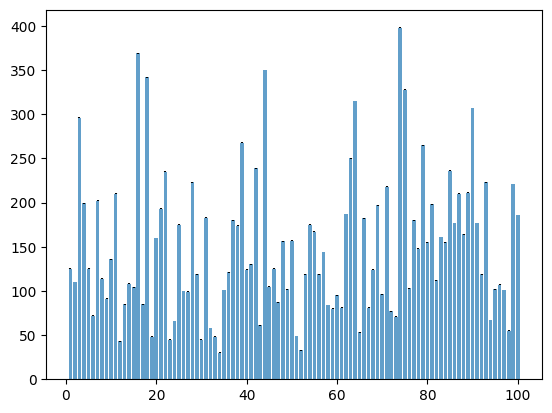

  0%|          | 0/100 [00:00<?, ?it/s]

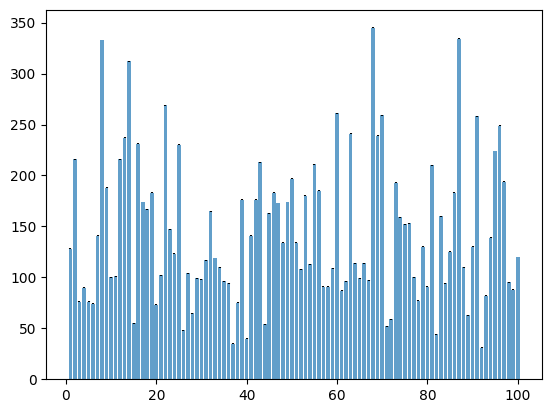

  0%|          | 0/100 [00:00<?, ?it/s]

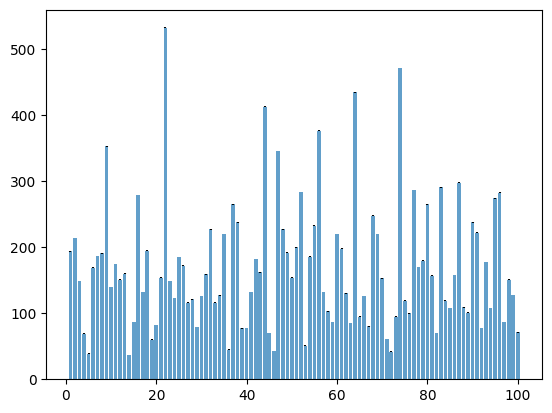

In [35]:
AGENT_CREATOR2 = AgentCreator(seed= SEED)
POP_AGENTS2 = AGENT_CREATOR2.create_agents(100)

means2 = []
stds2 = []

for rews in rewards:
    mean_t2 = []
    std_t2 = []
    for agent in tqdm(POP_AGENTS2):        
        taken_actions, given_rewards, after_rewards = ind_simulate(main_agent=agent, rewards=rews)
        desired_action = 0
        avg_perc2 = np.mean(taken_actions == desired_action, axis=0)
        std_perc2 = np.std(taken_actions == desired_action, axis = 0)
        a = list(np.asarray(avg_perc2 > 0.7).nonzero()[0])
        a.append(-1)
        mean_t2.append(a[0])
        std_t2.append(std_perc2[a[0]])
    
    means2.append(mean_t2)
    stds2.append(std_t2)
    plt.bar(list(range(1,101)), mean_t2, yerr = std_t2, alpha = 0.7)
    plt.show()


In [33]:
num_agents = 100 
pop_agents2 = {}

ALPHA_MEAN = 0.6
ALPHA_STD = 0.1

BETA_MEAN = 0.6
BETA_STD = 0.1

GAMMA_MEAN = 1.6
GAMMA_STD = 0.25

SEED = 313

np.random.seed(SEED)

for i in range(num_agents):
    a = np.random.normal(loc= ALPHA_MEAN, scale= ALPHA_STD)
    b = np.random.normal(loc= BETA_MEAN, scale= BETA_STD)
    c = np.random.normal(loc= GAMMA_MEAN, scale= GAMMA_STD)
    pop_agents2[i] = EpsilonGreedyAgent(epsilon = 0.1, alpha = a, beta = b, gamma = c)


env_class2 = []
num_arms = [10]
optimality_gaps = [1]
reward_values = [(-2,1),(-20,10),(-200,100)]
 
for k in num_arms:
    for opt_gap in optimality_gaps: 
        for rew_val in reward_values:
            Reward = [MultinomialReward([rew_val[0], rew_val[1]], [(i+1)/(opt_gap * k), 1- ((i+1)/(opt_gap * k))]) for i in range(k)]
            env = SocialMutliArmedBanditEnvironment(Reward, 10000)
            env_class2.append(env)

sbl2 = SocialBanditLearning(pop_agents2, env_class2, 1000, 50)
perc_opt_act2, regret2, average_utils2 = sbl2.run()
best_actions2, best_exp_u2 = sbl2.calculate_bests() 

100%|██████████| 50/50 [06:49<00:00,  8.19s/it]


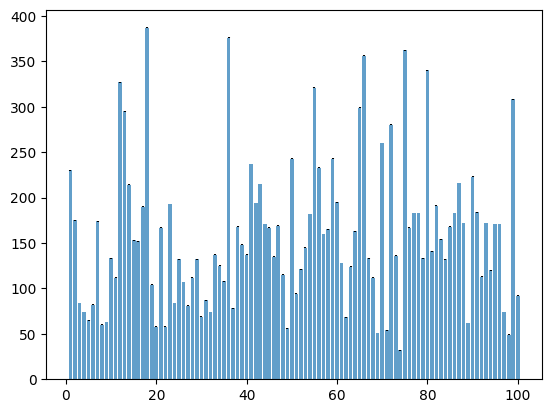

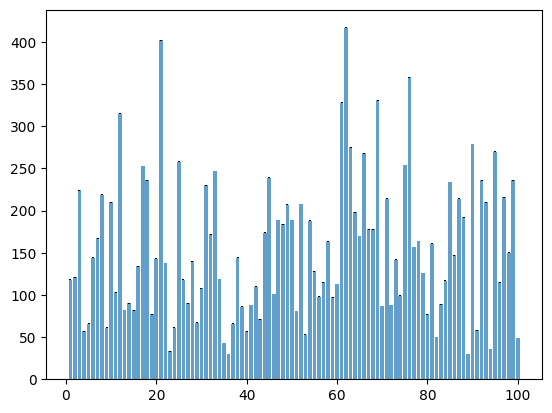

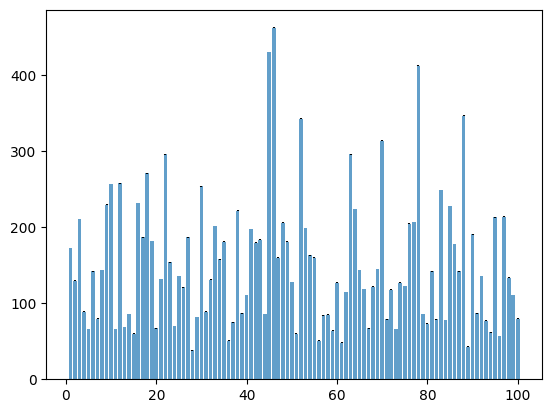

In [39]:
means2 = []
stds2 = []

for i in range(perc_opt_act2.shape[1]):
    mean_t2 = []
    std_t2 = []
    for j in  range(perc_opt_act2.shape[0]):
        avg_perc2 = np.average(perc_opt_act2[j,i,:,:],axis = 0)
        std_perc2 = np.std(perc_opt_act2[j,i,:,:],axis = 0)
        a = list(np.asarray(avg_perc2 > 0.7).nonzero()[0])
        a.append(-1)
        mean_t2.append(a[0])
        std_t2.append(std_perc2[a[0]])
    
    means2.append(mean_t2)
    stds2.append(std_t2)
    plt.bar(list(range(1,101)), mean_t2, yerr = std_t2, alpha = 0.7)
    plt.show()

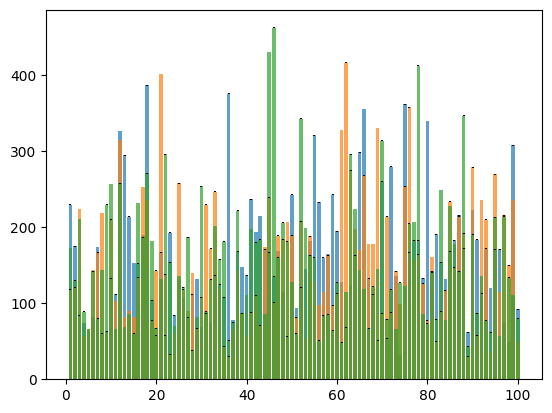

In [41]:
means2 = []
stds2 = []

for i in range(perc_opt_act2.shape[1]):
    mean_t2 = []
    std_t2 = []
    for j in  range(perc_opt_act2.shape[0]):
        avg_perc2 = np.average(perc_opt_act2[j,i,:,:],axis = 0)
        std_perc2 = np.std(perc_opt_act2[j,i,:,:],axis = 0)
        a = list(np.asarray(avg_perc2 > 0.7).nonzero()[0])
        a.append(-1)
        mean_t2.append(a[0])
        std_t2.append(std_perc2[a[0]])
    
    means2.append(mean_t2)
    stds2.append(std_t2)
    plt.bar(list(range(1,101)), mean_t2, yerr = std_t2, alpha = 0.7)
    # plt.show()

In [41]:
with open('results/budget_bernouli_means.pkl', 'wb') as f:
    pickle.dump(means2, f)

with open('results/budget_bernouli_stds.pkl', 'wb') as f:
    pickle.dump(stds2, f)


In [42]:
with open('results/budget_bernouli_means.pkl', 'rb') as f:
    means2 = pickle.load(f)

with open('results/budget_bernouli_means.pkl', 'rb') as f:
    stds2 = pickle.load(f)